In [1]:
###perovskite screening###

In [2]:
%matplotlib notebook
import ase.db
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta
from tabulate import tabulate
import seaborn as sns
import scipy as sp

In [3]:
dbase = ase.db.connect('cubic_perovskites.db')
# Do not include the so-called "reference systems"
syss=[c for c in dbase.select() if not hasattr(c,"reference")]

In [4]:
syss[0]._keys

['project',
 'A_ion',
 'anion',
 'combination',
 'CB_ind',
 'gllbsc_ind_gap',
 'heat_of_formation_all',
 'CB_dir',
 'gllbsc_dir_gap',
 'standard_energy',
 'B_ion',
 'VB_dir',
 'VB_ind']

In [5]:
Aset=set()
Bset=set()
anionset=set()
for p in syss:
    Aset.add(p.A_ion)
    Bset.add(p.B_ion)
    anionset.add(p.anion)
Alist=list(Aset)
Alist.sort()
Blist=list(Bset)
Blist.sort()
anionlist=list(anionset)
anionlist.sort()

In [6]:
# Anions: O,N,S,F
aniondict={'N3':[0,3,0,0],'O2F':[2,0,0,1], 'O2N':[2,1,0,0], 'O2S':[2,0,1,0],'O3':[3,0,0,0], 'OFN':[1,1,0,1],'ON2':[1,2,0,0]}

In [7]:
elemdict={'Ag':[5,11],
          'Al':[3,13],
          'As':[4,15],
          'Au':[6,11],
          'B':[2,13],
          'Ba':[6,2],
          'Be':[2,2],
          'Bi':[6,15],
          'Ca':[4,2],
          'Cd':[5,12],
          'Co':[4,9],
          'Cr':[4,6],
          'Cs':[6,1],
          'Cu':[4,11],
          'Fe':[4,8],
          'Ga':[4,13],
          'Ge':[4,14],
          'Hf':[6,4],
          'Hg':[6,12],
          'In':[5,13],
          'Ir':[6,9],
          'K':[4,1],
          'La':[6,2.5],
          'Li':[2,1],
          'Mg':[3,2],
          'Mn':[4,7],
          'Mo':[5,6],
          'Na':[3,1],
          'Nb':[5,5],
          'Ni':[4,10],
          'Os':[6,8],
          'Pb':[6,14],
          'Pd':[5,10],
          'Pt':[6,10],
          'Rb':[5,1],
          'Re':[6,7],
          'Rh':[5,9],
          'Ru':[5,8],
          'Sb':[5,15],
          'Sc':[4,3],
          'Si':[3,14],
          'Sn':[5,14],
          'Sr':[5,2],
          'Ta':[6,5],
          'Te':[5,16],
          'Ti':[4,4],
          'Tl':[6,13],
          'V':[4,5],
          'W':[6,6],
          'Y':[5,3],
          'Zn':[4,12],
          'Zr':[5,4]}

In [8]:
energies = [s.heat_of_formation_all for s in syss]

In [9]:
hist=plt.hist(energies,bins=100)

<IPython.core.display.Javascript object>

In [10]:
def finger(s):
    return np.concatenate([elemdict[s.A_ion],elemdict[s.B_ion],np.asarray(aniondict[s.anion])])

In [11]:
#test
# s=syss[3]
# a = finger(s)
# print(a)

####test sum matrix
# a = syss[2]
# b = syss[3]
# x = finger(a)
# xx =finger(b)
# print(x)
# print(xx)
# print((x-xx)**2)
# np.sum((x-xx)**2)

In [12]:
###testing###
trainset_test = np.random.choice(syss, 2, replace=False)
train_fp_test = np.array([finger(ts) for ts in trainset_test])
thfe_test = np.array([s.heat_of_formation_all for s in trainset_test])
print(trainset_test,train_fp_test, thfe_test)

 <ase.db.row.AtomsRow object at 0x000002B0BEC3EE80>] [[ 4  6  4  6  2  0  0  1]
 [ 3 13  5 11  2  1  0  0]] [0.56 2.02]


In [13]:
def initwithnoise():
    global N
    global xp
    global tp
    global sigma
    N = 10
    np.random.seed(seed=54)
    xp = np.sort(np.random.random_sample(N))
    np.random.seed(seed=58)
    sigma = 0.1
    tp = f(xp) + np.random.normal(0,sigma,N)

In [14]:
print(len(syss))

18928


In [15]:
#set the training/test sets
new_sys = np.random.permutation(syss)
trainset = new_sys[:500]
testset = new_sys[500:800]
train_fp = np.array([finger(ts) for ts in trainset])
test_fp = np.array([finger(ts) for ts in testset])
train_hfe = np.array([s.heat_of_formation_all for s in trainset])
test_hfe = np.array([s.heat_of_formation_all for s in testset])

In [16]:
class GP:
    "Class used for training and predicting using Gaussian process"
    def __init__ (self, l, k0, sigma): 
        self.l = l
        self.k0 = k0
        self.sigma = sigma
    def kernel(self, x, xx):
        "Calculates kernel"
        return np.exp(-(np.sum((x-xx)**2))/(2*self.l**2))

    def kvec(self, x):
        "calculates k-vector, x  is grid values"
        kvec = np.array([self.kernel(x,xx) for xx in xp])
        return kvec
    
    def calc_K(self, xp):
        "Calculates K matrix. xp is samples x-values"
        K =  np.array([[self.kernel(x,xx) for x in xp] for xx in xp])
        return K
    
    def calc_C(self, xp):
        "Calculates C matrix. xp is sample x-values"
        K = self.calc_K(xp)
        C = K + self.sigma**2*np.identity(len(xp))
        return C
    
    def fitf(self, x, Cinvt):
        "returns k-vector dotted with C_inv dot sample-y"
        return np.dot(self.kvec(x), Cinvt)
    
    def varx(self, x, Cinv):
        "Calculates the variance. Used as descriptor for errousness"
        return self.kernel(x,x)-np.dot(self.kvec(x), np.dot(Cinv, self.kvec(x)))
    
    def train(self, xp):
        "xp is x-values of samples, tp is y-values of samples. Returns C invers and C invers dotted with t"
        C = self.calc_C(xp)
        return C
   
    def predict(self, xp, tp, grid):
        "xp is x-values of sample points, tp is y-values of sample points, grid is the grid to be fitted to"
        C = self.train(xp)
        Cinv = np.linalg.inv(C)
        Cinvt = np.dot(Cinv, tp)
        fit_array = np.array([self.fitf(x, Cinvt) for x in grid])
        var_array = np.array([self.varx(x, Cinv) for x in grid])
        return fit_array, var_array


In [17]:
#basic parameters
l = 1.5
k0 = 0.5
sigma = 0.005
model = GP(l,k0,sigma)
xp = train_fp
tp = train_hfe
grid = test_fp

In [26]:
print(train_fp[1])
print(test_fp[1])
print(train_hfe[1])
print(test_hfe[1])

[ 6.  5.  6. 10.  1.  1.  0.  1.]
[6.  1.  6.  2.5 1.  2.  0.  0. ]
2.12
2.04


In [18]:
model.train(train_fp)

array([[1.00002500e+00, 1.27263380e-03, 3.92030244e-17, ...,
        7.49299871e-14, 2.26505216e-24, 4.11112291e-01],
       [1.27263380e-03, 1.00002500e+00, 1.12535175e-07, ...,
        4.62645934e-08, 2.10040929e-12, 1.98482958e-03],
       [3.92030244e-17, 1.12535175e-07, 1.00002500e+00, ...,
        1.98482958e-03, 5.56379983e-02, 5.20639411e-15],
       ...,
       [7.49299871e-14, 4.62645934e-08, 1.98482958e-03, ...,
        1.00002500e+00, 5.33159907e-07, 2.42054223e-11],
       [2.26505216e-24, 2.10040929e-12, 5.56379983e-02, ...,
        5.33159907e-07, 1.00002500e+00, 4.69154023e-22],
       [4.11112291e-01, 1.98482958e-03, 5.20639411e-15, ...,
        2.42054223e-11, 4.69154023e-22, 1.00002500e+00]])

In [19]:
fit_array, var_array = model.predict(xp, tp, grid)

In [20]:
# for each in grid:
#     print(model.kvec(each))
print(len(xp))
model.kvec(grid[1])

500


array([4.83299114e-12, 6.82560338e-08, 1.32944600e-07, 3.77907639e-20,
       1.91332754e-06, 4.78588490e-34, 1.97719537e-23, 1.73258520e-02,
       1.73258520e-02, 2.24694077e-08, 1.99665640e-01, 2.37778362e-17,
       4.01877094e-18, 2.85953277e-11, 5.46551592e-08, 4.71949527e-20,
       2.15316648e-13, 6.29854008e-07, 2.23596370e-19, 1.72412094e-13,
       5.04347663e-07, 2.66277056e-35, 9.19232160e-20, 5.31109225e-27,
       2.49352209e-01, 3.23377830e-07, 1.91332754e-06, 5.67568523e-14,
       4.74266479e-09, 1.52458823e-17, 1.02010953e-12, 7.22306887e-17,
       2.28973485e-11, 1.22079482e-17, 5.04347663e-07, 2.01485202e-26,
       2.56416878e-29, 9.63975726e-04, 1.59098679e-12, 1.11089965e-02,
       1.14798204e-19, 9.23744966e-09, 2.92829969e-03, 4.90097733e-26,
       4.29464934e-05, 8.80868737e-25, 1.62128791e-15, 2.37778362e-17,
       5.41224458e-30, 2.51624566e-26, 2.91399396e-14, 1.40686171e-16,
       3.65700376e-03, 3.94366198e-15, 2.67584296e-24, 9.72760477e-29,
      

<IPython.core.display.Javascript object>


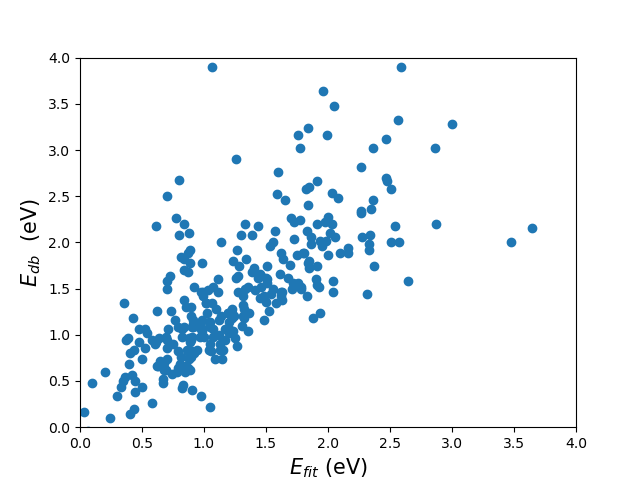

(0.0, 4.0)

In [22]:
#plot the prediction
plt.scatter(fit_array, test_hfe)
plt.xlabel('$E_{fit}$ (eV)',fontsize=15)
plt.ylabel('$E_{db}$  (eV)',fontsize=15)
plt.xlim(0,4)
plt.ylim(0,4)